# 2. Localization of vegetation data

## Introduction

**Purpose:** Assign [MODIS vegetation density data](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MYD13Q1/#product-information) to census tracts.

**Contents:** The notebook shows:
* The processing of satellite vegetation density data (NDVI, "normalized difference vegetation index") at 250 m resolution for Southern California into census tracts. Tract-level vegetation density is calculated as an average.

**Conclusions:** Key conclusions & outputs are:
* The SQLite database `greenspace.db` is updated, adding vegetation densities in the `ndvi` table. The table contains the average tract-level vegetation density data as measured on 17 May 2021.
* No analysis of the data is included here. This will be in a separate notebook.

## Import required libraries

In [1]:
# For conveniently assembling a list of files to open
import glob
import os

In [2]:
# For handling the TIFF imagery and converting to an array.
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent

In [3]:
# For mapping the data
import earthpy.plot as epp
import matplotlib.pyplot as plt

In [4]:
# For manipulating geographic data
import geopandas as gpd
import contextily as cx

In [5]:
# For manipulating arrays
import numpy as np

## Open the satellite imagery
MODIS satellite imagery is available in 16-day increments. Somewhat arbitrarily, we'll work with the 137th day of 2021 (May 17) in this notebook. In future work, it may be interesting to look for changes in vegetation density over time.

In [6]:
# Make a list of all the TIFF images for the date of interest.
modis_raw_list = glob.glob(os.path.join("data",
                                        "modis-images",
                                        "MYD13Q1.061*2021137*.tif"))
modis_raw_list

['data/modis-images/MYD13Q1.061__250m_16_days_pixel_reliability_doy2021137_aid0001.tif',
 'data/modis-images/MYD13Q1.061__250m_16_days_NDVI_doy2021137_aid0001.tif',
 'data/modis-images/MYD13Q1.061__250m_16_days_VI_Quality_doy2021137_aid0001.tif',
 'data/modis-images/MYD13Q1.061__250m_16_days_EVI_doy2021137_aid0001.tif']

Four images are found: two related to vegetation density (`...NDVI...` and `...EVI...`), and two related to the quality of the data.

We'll want to open the TIFF images and convert them to a single, multilayered `xarray`. This function will do the heavy lifting:

In [7]:
def combine_tifs(tif_list):
    """This function accepts a list of paths to tif files and combines them into an xarray.
    
    ===> Inputs:
        tif_list (list): A list of paths to the tif files.
         

    ===> Returns:
        An xarray containing the combined tif files.
    """
    
    xarr_out = []
    for i, tif_path in enumerate(tif_list):
        xarr_out.append(rxr.open_rasterio(tif_path, masked = True).squeeze())
        xarr_out[i]['band'] = i + 1
        
    return xr.concat(xarr_out, dim = 'band')

Call the new function to convert the images into an array:

In [8]:
modis_raw = combine_tifs(modis_raw_list)
modis_raw.shape

(4, 1074, 1223)

## Spot check: Map the imagery data
Before moving on, let's map the satellite imagery to ensure that everything looks as expected.

Extract the name of each layer.That will become the title for each trial map.

In [9]:
titles = [title.split("16_days_")[1].split("_doy")[0] for title in modis_raw_list]
titles

['pixel_reliability', 'NDVI', 'VI_Quality', 'EVI']

Plot each of the layers ("bands") within the array of image data.

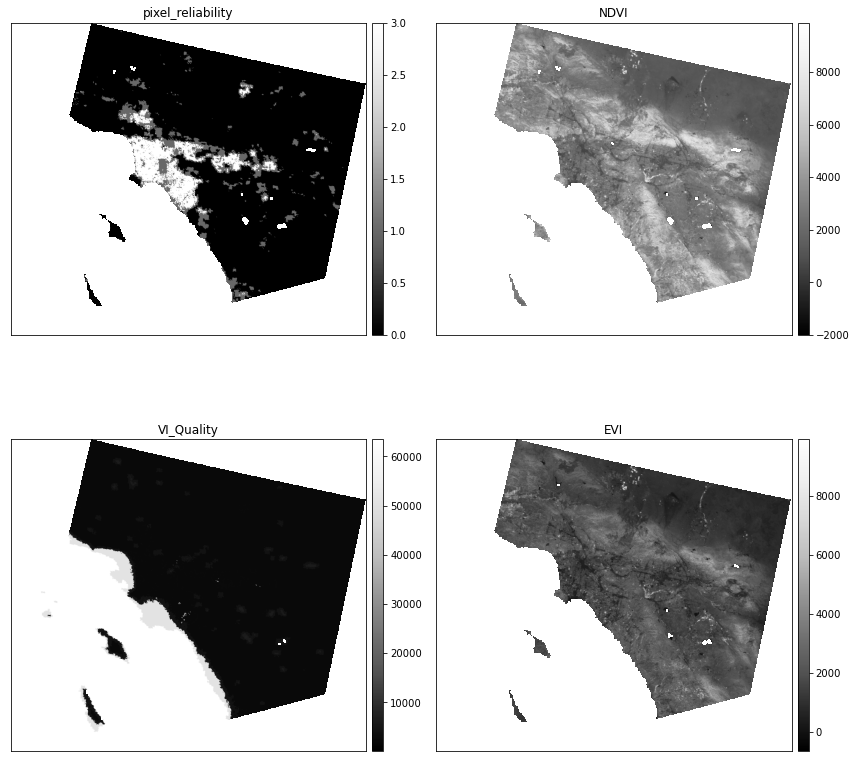

In [10]:
epp.plot_bands(modis_raw.values,
               cols = 2,
               title = titles)
plt.show()

Define which layer number (0-indexing) contains the NDVI data. This will make life a little easier down the road.

In [11]:
ndvi_layer = 1

## Load the census tract definitions
Import the boundaries of each census tract from a [shapefile provided by the US Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html). The shapefile contains every census tract in California.

In [12]:
tracts = gpd.read_file("data/census-tracts/tl_2020_06_tract.shp")
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,029,004402,06029004402,44.02,Census Tract 44.02,G5020,S,1865739,0,+35.5917343,-119.3337642,"POLYGON ((-119.33828 35.58143, -119.33827 35.5..."
1,06,047,000802,06047000802,8.02,Census Tract 8.02,G5020,S,2321653,0,+37.3433591,-120.5854604,"POLYGON ((-120.59599 37.34121, -120.59596 37.3..."
2,06,085,501402,06085501402,5014.02,Census Tract 5014.02,G5020,S,522620,0,+37.3453341,-121.8665169,"POLYGON ((-121.87381 37.34412, -121.87361 37.3..."
3,06,005,000102,06005000102,1.02,Census Tract 1.02,G5020,S,456204155,7940832,+38.5496993,-120.2509786,"POLYGON ((-120.61016 38.41560, -120.61000 38.4..."
4,06,029,004901,06029004901,49.01,Census Tract 49.01,G5020,S,1459379,0,+35.7837173,-119.2462266,"POLYGON ((-119.25262 35.79043, -119.25259 35.7..."


In [13]:
print("There are {} census tracts in the state of California.".format(len(tracts)))

There are 9129 census tracts in the state of California.


Because the dataset includes every census tract in California, there is a **lot** of unnecessary data here. We can filter down to just the two counties of interest: Los Angeles (FIPS code 037) and Orange (FIPS code 059).

In [14]:
tracts = tracts[tracts["COUNTYFP"].isin(["037", "059"])]

Spot-check the filtered census tracts to make sure the geographic area has been restricted correctly:

<AxesSubplot:>

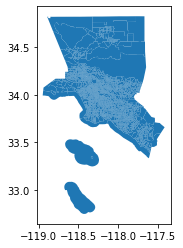

In [15]:
tracts.plot()

Great! That looks like Los Angeles and Orange Counties.

## Visualize vegetation data within census tracts
Next, let's visually inspect the vegetation density data with a map of census tracts superimposed.

To do that, the census tract data needs to use the same coordinate reference system as the satellite imagery.

In [16]:
tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [17]:
tracts = tracts.to_crs(modis_raw.rio.crs)
tracts.crs

<Derived Projected CRS: PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984", ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next, actually map the satellite imagery data:

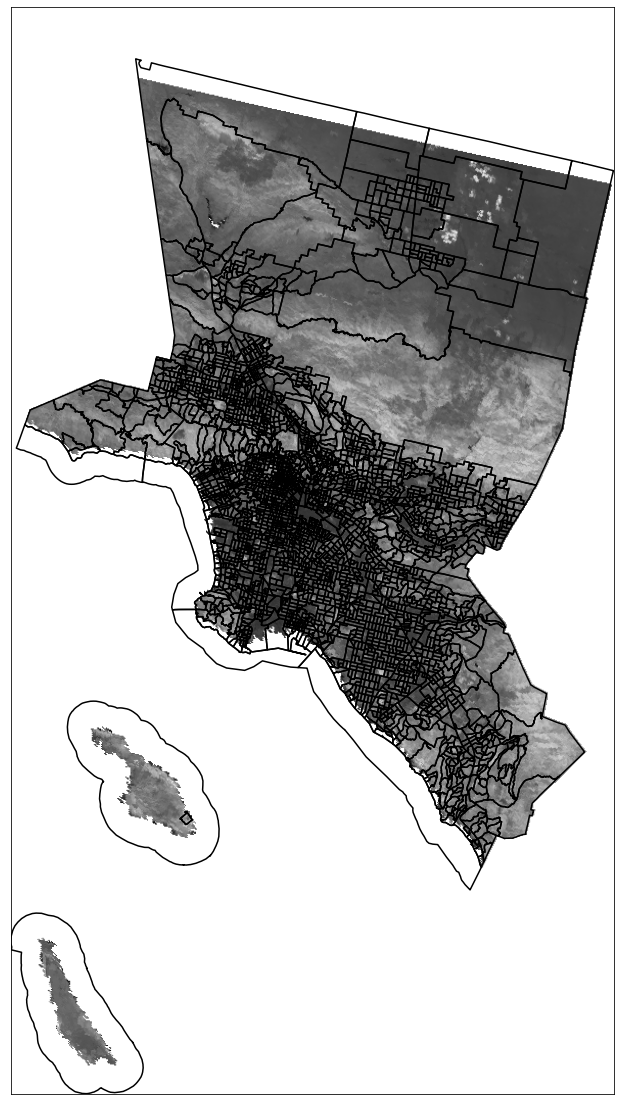

In [18]:
# Clip the satellite imagery to the geometry of the tracts
modis_clipped = modis_raw.rio.clip(tracts.geometry,
                                               all_touched = True)

# Establish the geographic bounds of the plot
extent = plotting_extent(modis_clipped[ndvi_layer].values, modis_clipped.rio.transform())

# Build the map
fig, ax = plt.subplots(figsize=(20, 20))

epp.plot_rgb(modis_clipped.values,
            rgb=[ndvi_layer, ndvi_layer, ndvi_layer],
            ax=ax,
            extent=extent)

tracts.boundary.plot(ax=ax,
                     color = "black")

plt.show()

Super. The satellite imagery from MODIS is properly aligned with the cropping boundaries of the census tract data.

### What's the relative scale of a MODIS pixel vs. a census tract?
That is, which one is bigger? This will give a better understanding of how to derive one single NVDI value for each census tract.

To answer that question, let's build a map of just a few census tracts.

<AxesSubplot:>

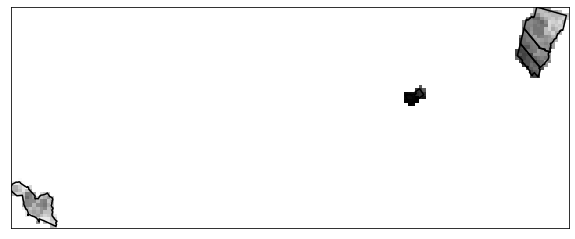

In [19]:
# Examine only the first few census tracts listed.
tract_subset = tracts.head()

# Clip the MODIS data to the geometry of the tracts
modis_clipped = modis_raw.rio.clip(tract_subset.geometry,
                                               all_touched = True)

# Establish the geographic bounds of the plot
extent = plotting_extent(modis_clipped[ndvi_layer].values, modis_clipped.rio.transform())

# Build the plot
fig, ax = plt.subplots(figsize=(10, 10))

epp.plot_rgb(modis_clipped.values,
            rgb=[ndvi_layer, ndvi_layer, ndvi_layer],
            ax=ax,
            extent=extent)

tract_subset.boundary.plot(ax=ax,
                     color = "black")


A census tract contains > 1 pixel of MODIS imagery data. With that in mind, one way to determine a single NVDI value for each tract is simply to take the average value of each pixel that is in (or partially in) the tract.

## Determine NDVI for each tract
With that groundwork laid, it's time to assign a single vegetation density value to each census tract. We'll use the approach outlined above, in which the values for each pixel in (or partially in) a census tract are averaged.

In future work, it would be preferable to handle border cases by determining what percentage of each pixel actually lies within the tract boundaries. That would enable a weighted average of all the portions of pixels actually inside the tract.

Define a function to calculate the average NVDI value for each census tract:

In [20]:
def calc_mean_ndvi(row, mean_ndvi_colname):
    
    try:
        clip = modis_raw.rio.clip([row.geometry],
                                  all_touched = True)

        # Extract only the NVDI layer and convert to a  native numpy array
        clip = np.array(clip[ndvi_layer])


        # Remove NaN values.
        clip = clip[np.logical_not(np.isnan(clip))]

        # Calculate mean NVDI within this region, correcting for the data's
        # inherent scaling factor (10000) to obtain proper values in the
        # range of (-1, 1).

        scaling = 10000
        row[mean_ndvi_colname] = clip.mean() / scaling
        
    except rxr.exceptions.NoDataInBounds:
        # If no NVDI data can be found for the clipped region, write nan.
        row[mean_ndvi_colname] = np.nan
        
    except np.RuntimeWarning:
        row[mean_ndvi_colname] = np.nan

    return row

In testing this function, I found that there are `RuntimeWarnings` that are periodically raised for "mean of empty slice." Supress them because they are ugly.

In [21]:
import warnings
warnings.filterwarnings("ignore")

Call the function to calculate the NDVI values for each tract:

In [22]:
tracts = tracts.apply(calc_mean_ndvi,
                      mean_ndvi_colname = "NDVI_20210517",
                      axis = "columns")

Spot-check that this function has worked as expected:

In [23]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NDVI_20210517
17,06,037,262601,06037262601,2626.01,Census Tract 2626.01,G5020,S,3620351,0,+34.0738344,-118.5557893,"POLYGON ((-2048516.056 1468406.793, -2048425.5...",0.469434
62,06,037,300100,06037300100,3001,Census Tract 3001,G5020,S,4591342,18657,+34.2442558,-118.2325716,"POLYGON ((-2015282.560 1478655.361, -2015268.0...",0.418855
65,06,037,300501,06037300501,3005.01,Census Tract 3005.01,G5020,S,1260255,0,+34.2206887,-118.2400494,"POLYGON ((-2015719.635 1476884.936, -2015713.8...",0.265917
78,06,037,310701,06037310701,3107.01,Census Tract 3107.01,G5020,S,515339,0,+34.1853923,-118.3128440,"POLYGON ((-2022989.609 1474306.145, -2022953.6...",0.156655
211,06,037,300200,06037300200,3002,Census Tract 3002,G5020,S,1943986,10136,+34.2283768,-118.2386852,"POLYGON ((-2015431.033 1478051.321, -2015410.7...",0.339691


## Map it!
Build a map to visualize the vegetation density in each census tract.

First, drop any census tracts with null values in the new NDVI column.

In [24]:
tracts = tracts.dropna(axis = "index",
                       subset = ["NDVI_20210517"])

The CRS of the `tracts` dataframe was modified when plotting the MODIS satellite imagery, and it has not been cooperative in changing it back. That's important because it would be nice to have a base map underlaying geographic landmarks alongside the vegetation density data. 

As a hacky but quick workaround, we will just re-load the census tract shapefile as `mapping` and copy in the vegetation index information from `tracts`.

In [25]:
tracts = tracts.set_index("GEOID")
mapping = gpd.read_file("data/census-tracts/tl_2020_06_tract.shp").set_index("GEOID")
mapping["NDVI_20210517"] = tracts["NDVI_20210517"]

Drop any tracts that do not contain any any land. Some census tracts are just water, which is odd.

In [26]:
noland = mapping[mapping["ALAND"] == 0].index
mapping = mapping.drop(noland, axis = "index")

I made the stylistic choice to drop Catalina Island (off the southern coast, FIPS codes 6037599100 and 6037599000) from the map, simply because having it there makes the map scale in an ugly way:

In [27]:
mapping = mapping.drop(["06037599100", "06037599000"], axis = "index")

Then, build a simple map:

Text(1182.7800000000002, 0.5, 'Green Space\n(NDVI, higher = more vegetation)')

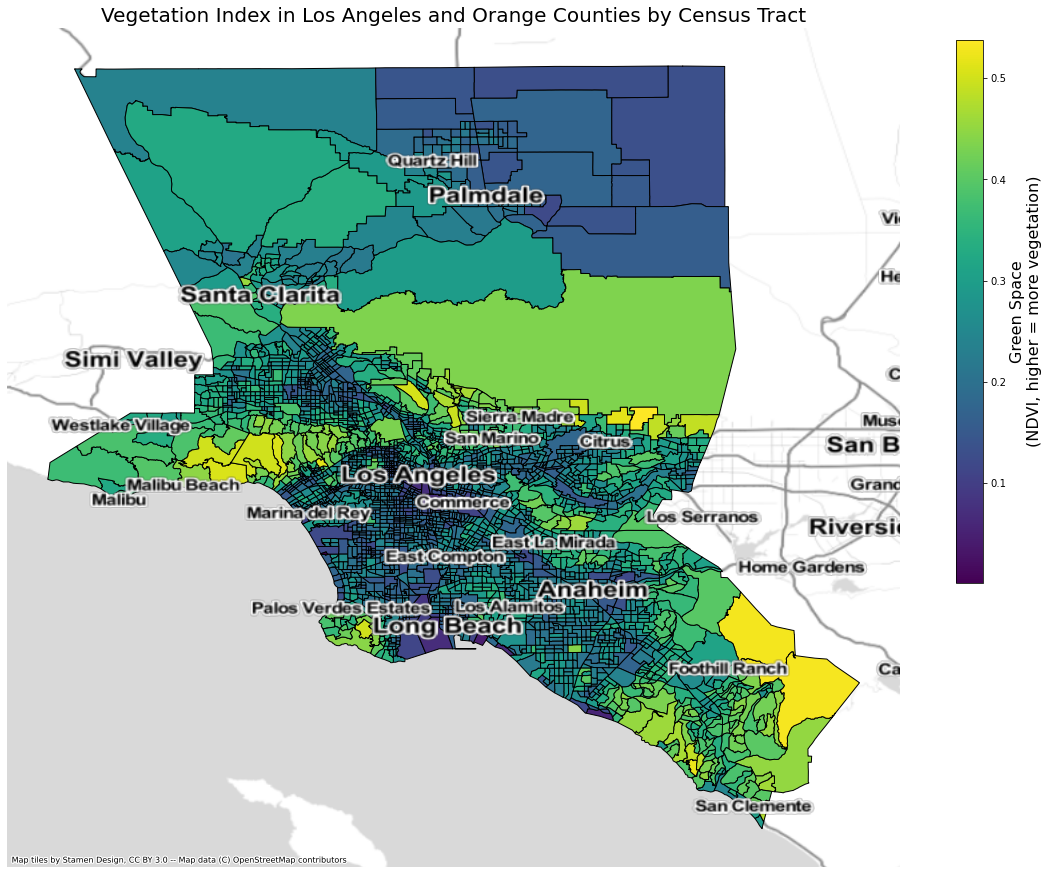

In [28]:
map = mapping.plot(column = "NDVI_20210517",
                  figsize = (20, 20),
                  legend = True,
                  cmap = "viridis",
                  alpha = 1,
                  edgecolor = "black",
                  legend_kwds = {"shrink" : 0.5,
                                 "anchor" : (0, 0.75),
                                 "ticks" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
                                })
# Include an underlay map for context.
cx.add_basemap(map,
               crs = mapping.crs,
               source = cx.providers.Stamen.TonerLite)
cx.add_basemap(map,
               crs = mapping.crs,
               source = cx.providers.Stamen.TonerLabels)

# Add titles & labels
map.axis("off")
map.set_title("Vegetation Index in Los Angeles and Orange Counties by Census Tract", fontsize = 20)
map.get_figure().get_axes()[1].set_ylabel("Green Space\n(NDVI, higher = more vegetation)", size = 16)

In [29]:
map.get_figure().savefig("images/map.png")

## Create & update the database
Finally, we'll write the tract-level NDVI data to a SQL database.

First, create a new dataframe from `tracts` containing the tract-level FIPS codes (currently in the index), the tract's land area (`ALAND`, in square meters) and the NDVI data:

In [30]:
ndvi = tracts[["NDVI_20210517", "ALAND"]]
ndvi.index.name = "Tract_FIPS"
ndvi.columns = ["NDVI_20210517", "Land_area_m2"]
ndvi.head()

,NDVI_20210517,Land_area_m2
Tract_FIPS,,
06037262601,0.469434,3620351
06037300100,0.418855,4591342
06037300501,0.265917,1260255
06037310701,0.156655,515339
06037300200,0.339691,1943986


Then, write to the `ndvi` table in the `vegetation` database:

In [31]:
from sqlalchemy import create_engine

In [32]:
with create_engine("sqlite:///greenspace.db").connect() as db:
    ndvi.to_sql("ndvi", db)